# Imports

In [ ]:
import os
import torch
import numpy as np
import torch
from torch.autograd import Function
import torch
import torch.nn.functional as F
import torch.nn as nn

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader, NodeLoader
import networkx as nx

# Utilities

## models

In [ ]:
# torch.manual_seed(1234567)


class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, dann_lambda = 0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.domain_classifier = GCNConv(hidden_channels, 2)
        self.dann_lambda = dann_lambda

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        y_class = self.conv2(x, edge_index)

        reverse_feature = ReverseLayerF.apply(x, self.dann_lambda)
        y_domain = self.domain_classifier(reverse_feature, edge_index)

        return y_class, y_domain


from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8, dann_lambda = 0.5):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.domain_classifier = GATv2Conv(dim_h*heads, 2, heads=1)
        self.dann_lambda = dann_lambda


    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        y_class = self.gat2(h, edge_index)

        reverse_feature = ReverseLayerF.apply(h, self.dann_lambda)
        y_domain = self.domain_classifier(reverse_feature, edge_index)

        return y_class, y_domain

## datasets

In [ ]:
# creates diagonal probabilities for the sbm model. p/q are intra/inter class probability
def create_symmetric_block_probs(n_blocks, p, q):
  probs = []
  for i in range(n_blocks):
    block_probs = q*np.ones(n_blocks)
    block_probs[i] = p
    probs.append(block_probs.tolist())

  return probs





# creates an sbm symmetric dataset using pytorch geometric and returns nodes and edges
def create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root='.'):
  block_sizes = [block_size]*n_blocks
  block_probs = create_symmetric_block_probs(n_blocks, intra_block_prob, inter_block_prob)
  dataset = StochasticBlockModelDataset(root=root , block_sizes = block_sizes, edge_probs = block_probs,
                                          num_channels = n_node_features)
  return dataset[0]




# creates dataloaders for target and source
def create_sbm_symmetric_transfer_dataloaders(dataset_s, dataset_t):
  x_src = dataset_s.x
  x_tgt = dataset_t.x

  edge_src = dataset_s.edge_index
  edge_tgt = dataset_t.edge_index

  #same features
  # x_src = torch.Tensor(np.ones_like(x_src))
  # x_tgt = torch.Tensor(np.ones_like(x_tgt))

  y_src = dataset_s.y
  y_tgt = dataset_t.y


  dataset_src = Data(x=x_src, edge_index = edge_src)
  dataset_tgt = Data(x=x_tgt, edge_index = edge_tgt)
  dataset_src.y = y_src
  dataset_tgt.y = y_tgt


  return dataset_src, dataset_tgt



# high-level transfer experiments with symmetric sbm datasets
def create_transfer_symmetric_sbm_datasets(root = '.', block_size = 300, n_blocks = 5, n_node_features = 100, source_probs = [0.8, 0.1], target_probs = [0.1, 0.8]):
  # source dataset
  intra_block_prob = source_probs[0]
  inter_block_prob = source_probs[1]
  dataset_s = create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root = root + '/src')


  # target dataset
  intra_block_prob = target_probs[0]
  inter_block_prob = target_probs[1]
  dataset_t = create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root = root + '/tgt')

  return create_sbm_symmetric_transfer_dataloaders(dataset_s, dataset_t)






## train

In [ ]:
#simple training loop. returns losses
class Trainer():
  def __init__(self, device, model, data_src, data_tgt, optimizer, criterion, transfer = True, transfer_type = 'dann', log_epochs = True):

    self.device = device
    self.model = model
    self.data_src = data_src
    self.data_tgt = data_tgt
    self.optimizer = optimizer
    self.criterion = criterion

    self.transfer = transfer
    self.transfer_type = transfer_type
    self.log_epochs = log_epochs

    losses = dict()
    losses['source'] = []

    if transfer:
      losses['target'] = []
      losses['target_acc'] = []
      if transfer_type == 'dann':
        losses['discriminator'] = []

    losses['total'] = []

    self.losses = losses






  def train(self, epochs = 5):
    # data_src = NodeLoader(data_src, batch_size = 100, shuffle = False)
    # data_tgt = NodeLoader(data_tgt, batch_size = 100, shuffle = False)


    if self.log_epochs == True:

      print('Training!')
      from tqdm import tqdm
      epochs_iterable = tqdm(range(epochs))

    else: epochs_iterable = range(epochs)




    for epoch in epochs_iterable:

        self.model.train()
        self.optimizer.zero_grad()

        #forward
        cls_src_preds, domain_src_preds = self.model(self.data_src.x, self.data_src.edge_index)

        if self.transfer:
          cls_tgt_preds, domain_tgt_preds = self.model(self.data_tgt.x, self.data_tgt.edge_index)

        # source classification loss
        src_cls_loss = self.criterion(cls_src_preds, self.data_src.y)


        # transfer learning experiment
        if self.transfer:
          #adversarial discriminator loss
          if self.transfer_type == 'dann':
            domain_dsc_src_loss = self.criterion(domain_src_preds, torch.ones_like(domain_src_preds).to(self.device))
            domain_dsc_tgt_loss = self.criterion(domain_tgt_preds, torch.zeros_like(domain_tgt_preds).to(self.device))
            discriminator_loss = domain_dsc_src_loss/2

          total_loss = discriminator_loss + src_cls_loss


        #optimizer step
        total_loss.backward()
        self.optimizer.step()




        #store losses
        self.losses['source'].append(src_cls_loss.detach().cpu().numpy())
        self.losses['total'].append(total_loss.detach().cpu().numpy())

        if self.transfer:
          eval_loss = self.criterion(cls_tgt_preds, self.data_tgt.y)
          self.losses['target'].append(eval_loss.detach().cpu().numpy())

          # self.losses['target_acc'].append(eval_cls_preds(cls_tgt_preds, self.data_tgt.y))


          if self.transfer_type == 'dann':
            self.losses['discriminator'].append(discriminator_loss.detach().cpu().numpy())


    if self.log_epochs == True: print('\nDone')







## evaluations

In [ ]:
def plot_losses(losses, title = ".", keys = ['source', 'target', 'discriminator', 'total']):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set_theme()

  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


  legends = list(keys)
  for key in keys:
    plt.plot(losses[key])

  plt.legend(legends)




def eval_cls_preds(cls_preds, y_true):
  preds = cls_preds.argmax(dim=1)

  num_samples = preds.shape[0]
  correct = int((preds == y_true).sum())
  acc = correct / num_samples

  return acc




def eval_model_acc(model, data):
  model.eval()
  cls_preds, _ = model(data.x, data.edge_index)
  return eval_cls_preds(cls_preds, data.y)


# Experiments

## Experiment loop

In [ ]:
def multiple_experiments(n_experiments, epochs, dann_lambda = 1, n_node_features = 10, model_type = 'GCN',
                         source_probs = [0.9, 0.1], target_probs = [0.9, 0.1], lr = 0.02):

  # initializations
  from tqdm import tqdm
  src_accs = np.zeros(n_experiments)
  tgt_accs = np.zeros(n_experiments)

  keys = ['source', 'target', 'total', 'discriminator']
  avg_losses = dict()
  for key in keys:
    avg_losses[key] = np.zeros(n_epochs)



  # experiments loop
  for experiment in tqdm(range(n_experiments)):
    n_classes = 2
    block_size = 100


    data_src, data_tgt = create_transfer_symmetric_sbm_datasets(root = f'./datasets/{experiment}', block_size = block_size, n_blocks = n_classes, n_node_features = n_node_features,
                                                                source_probs = source_probs, target_probs = target_probs)

    # model declaration
    dim_h = 8
    gat_heads = 8
    if model_type == 'GCN':
      model = GCN(hidden_channels=dim_h, num_features = n_node_features, num_classes = n_classes, dann_lambda = dann_lambda)

    elif model_type == 'GAT':
      model = GAT(dim_in = n_node_features, dim_h = dim_h, dim_out = n_classes, heads = gat_heads, dann_lambda = dann_lambda)


    # training stuff initializations
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_src = data_src.to(device)
    data_tgt = data_tgt.to(device)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # training loop
    trainer = Trainer(device, model, data_src, data_tgt, optimizer, criterion, epochs, log_epochs = False)
    trainer.train(epochs = n_epochs)
    losses = trainer.losses


    # store losses
    for key in keys:
      avg_loss = np.array(losses[key])
      avg_loss /= n_experiments
      avg_losses[key] += avg_loss

    src_accs[experiment] = eval_model_acc(model, data_src)
    tgt_accs[experiment] = eval_model_acc(model, data_tgt)


  return avg_losses, src_accs, tgt_accs

## Experiments

### Basic Structure Shift

In [ ]:
# Experiment parameters
model_type = 'GAT'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.005

p = 0.7
q = 0.3


experiments = ['hemoph', 'heteroph', 'hemoph_to_heteroph', 'heteroph_to_hemoph']
experiments_descriptions = ['Hemophilic - No Structure Shift', 'Heterophilic - No Structure Shift', 'Hemophilic to Heterophilic Structure Shift', 'Heterophilic to Homophilic Structure Shift']
n_experiments = len(experiments)

results = dict()

for key in experiments:
  results[key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs
experiments_source_probs = [[p, q], [q, p], [p, q], [q, p]]
experiments_target_probs = [[p, q], [q, p], [q, p], [p, q]]


# run experiments
for exp_ind in range(n_experiments):
  source_probs = experiments_source_probs[exp_ind]
  target_probs = experiments_target_probs[exp_ind]

  key = experiments[exp_ind]
  avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

  # save results
  results[key]['avg_losses'] = avg_losses
  results[key]['src_accs'] = src_accs
  results[key]['tgt_accs'] = tgt_accs


100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


In [ ]:
# Experiment parameters
model_type = 'GCN'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.02


experiments = ['hemoph', 'heteroph', 'hemoph_to_heteroph', 'heteroph_to_hemoph']
experiments_descriptions = ['Hemophilic - No Structure Shift', 'Heterophilic - No Structure Shift', 'Hemophilic to Heterophilic Structure Shift', 'Heterophilic to Homophilic Structure Shift']
n_experiments = len(experiments)

results = dict()

for key in experiments:
  results[key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs for all experiments
p = 0.6
q = 0.3

experiments_source_probs = [[p, q], [q, p], [p, q], [q, p]]
experiments_target_probs = [[p, q], [q, p], [q, p], [p, q]]


# run experiments
for exp_ind in range(n_experiments):
  source_probs = experiments_source_probs[exp_ind]
  target_probs = experiments_target_probs[exp_ind]

  key = experiments[exp_ind]
  avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

  # save results
  results[key]['avg_losses'] = avg_losses
  results[key]['src_accs'] = src_accs
  results[key]['tgt_accs'] = tgt_accs


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


### Source Structure Effect

In [ ]:
# Experiment parameters
model_type = 'GAT'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.005

p = 0.7
q = 0.3


experiments = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']
experiments_descriptions = ['Structure 1', 'Structure 2', 'Structure 3', 'Structure 4', 'Structure 5']
n_experiments = len(experiments)


n_target_probs = 2
all_results = []

for i in range(n_target_probs):
  all_results.append(dict())

for key in experiments:
  results[key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs
step = 0.1
experiments_source_probs = [[p, q], [p - step, q + step], [p - 2*step, q + 2*step], [p - 3*step, q + 3*step], [p - 4*step, q + 4*step]]
experiments_target_probs = [[p, q], [q, p]]


# run experiments
for exp_ind in range(n_experiments):

  key = experiments[exp_ind]
  source_probs = experiments_source_probs[exp_ind]

  for target_struct_ind in range(n_target_probs):
    target_probs = experiments_target_probs[target_struct_ind]
    avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

    # save results
    all_results[target_struct_ind][key]['avg_losses'] = avg_losses
    all_results[target_struct_ind]['src_accs'] = src_accs
    all_results[target_struct_ind]['tgt_accs'] = tgt_accs


In [ ]:
# Experiment parameters
model_type = 'GCN'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.02


experiments = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']
experiments_descriptions = ['Structure 1', 'Structure 2', 'Structure 3', 'Structure 4', 'Structure 5']
n_experiments = len(experiments)


n_target_probs = 2
all_results = []

for i in range(n_target_probs):
  all_results.append(dict())

  for key in experiments:
    all_results[i][key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs
step = 0.1
experiments_source_probs = [[p, q], [p - step, q + step], [p - 2*step, q + 2*step], [p - 3*step, q + 3*step], [p - 4*step, q + 4*step]]
experiments_target_probs = [[p, q], [q, p]]


# run experiments
for exp_ind in range(n_experiments):

  key = experiments[exp_ind]
  source_probs = experiments_source_probs[exp_ind]

  for target_struct_ind in range(n_target_probs):
    target_probs = experiments_target_probs[target_struct_ind]
    avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

    # save results
    all_results[target_struct_ind][key]['avg_losses'] = avg_losses
    all_results[target_struct_ind][key]['src_accs'] = src_accs
    all_results[target_struct_ind][key]['tgt_accs'] = tgt_accs

 27%|██▋       | 8/30 [00:03<00:08,  2.62it/s]

### Edges

In [ ]:
# Experiment parameters
model_type = 'GCN'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.02


experiments = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']
experiments_descriptions = ['Structure 1', 'Structure 2', 'Structure 3', 'Structure 4', 'Structure 5']
n_experiments = len(experiments)


n_target_probs = 2
all_results = []

for i in range(n_target_probs):
  all_results.append(dict())

  for key in experiments:
    all_results[i][key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs
sp = 0.001
experiments_source_probs = [[sp, sp], [sp, sp], [sp, sp], [sp, sp], [sp, sp]]
experiments_target_probs = [[sp,sp], [sp, sp]]


# run experiments
for exp_ind in range(n_experiments):

  key = experiments[exp_ind]
  source_probs = experiments_source_probs[exp_ind]

  for target_struct_ind in range(n_target_probs):
    target_probs = experiments_target_probs[target_struct_ind]
    avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

    # save results
    all_results[target_struct_ind][key]['avg_losses'] = avg_losses
    all_results[target_struct_ind][key]['src_accs'] = src_accs
    all_results[target_struct_ind][key]['tgt_accs'] = tgt_accs

100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


# Results

## Basic Transfer

### GCN

In [ ]:
model = 'GCN'

print(f'{model} Transfer Results\n')
for exp_ind in range(n_experiments):
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, variance = {src_accs.var():.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, variance = {tgt_accs.var():.4f}')
  print("\n\n\n")


GCN Transfer Results

Hemophilic - No Structure Shift
Source Accuracy: mean = 0.9995, variance = 0.0000
Target Accuracy: mean = 0.9168, variance = 0.0201




Heterophilic - No Structure Shift
Source Accuracy: mean = 0.9992, variance = 0.0000
Target Accuracy: mean = 0.9015, variance = 0.0229




Hemophilic to Heterophilic Structure Shift
Source Accuracy: mean = 0.9993, variance = 0.0000
Target Accuracy: mean = 0.9440, variance = 0.0145




Heterophilic to Homophilic Structure Shift
Source Accuracy: mean = 0.9987, variance = 0.0000
Target Accuracy: mean = 0.9027, variance = 0.0274






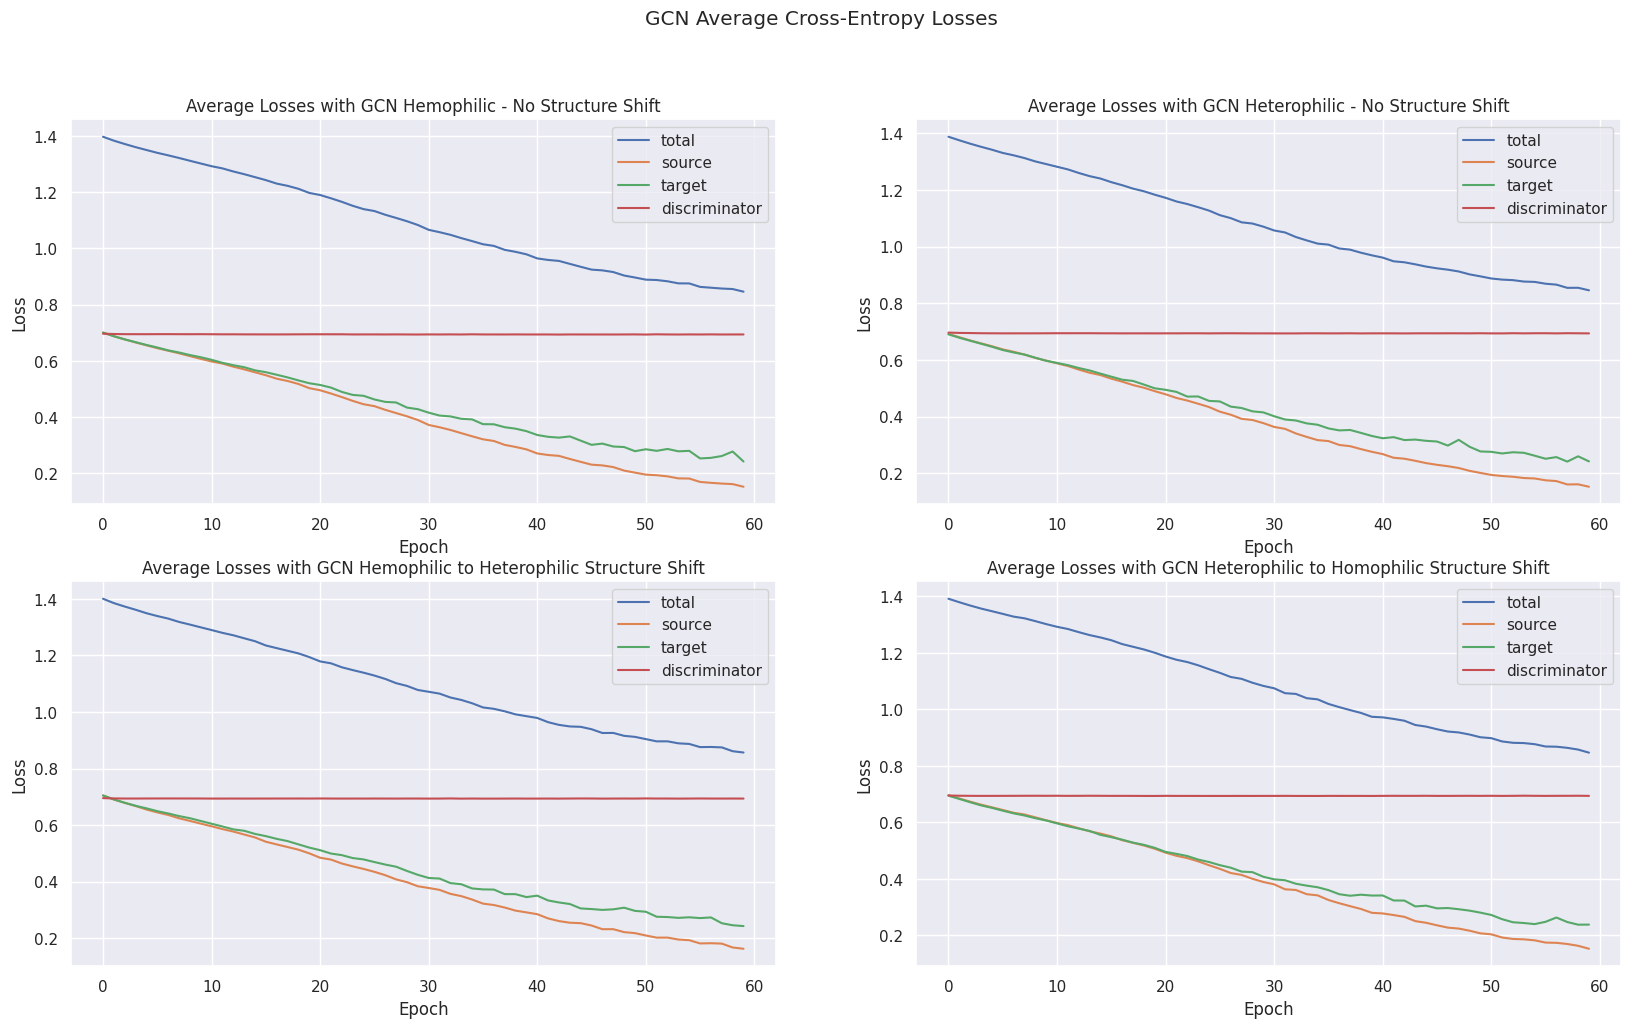

In [ ]:
import matplotlib.pyplot as plt

model = 'GCN'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['total', 'source', 'target', 'discriminator']




for exp_ind in range(n_experiments):
  plt.subplot(2,2, exp_ind + 1)

  key = experiments[exp_ind]
  plot_losses(results[key]['avg_losses'], title=f'Average Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()

### GAT

In [ ]:
model = 'GAT'

print(f'{model} Transfer Results\n')
for exp_ind in range(n_experiments):
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, variance = {src_accs.var():.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, variance = {tgt_accs.var():.4f}')
  print("\n\n\n")


GAT Transfer Results

Hemophilic - No Structure Shift
Source Accuracy: mean = 0.9288, variance = 0.0221
Target Accuracy: mean = 0.9087, variance = 0.0307




Heterophilic - No Structure Shift
Source Accuracy: mean = 0.9148, variance = 0.0241
Target Accuracy: mean = 0.8808, variance = 0.0373




Hemophilic to Heterophilic Structure Shift
Source Accuracy: mean = 0.9483, variance = 0.0136
Target Accuracy: mean = 0.5568, variance = 0.0173




Heterophilic to Homophilic Structure Shift
Source Accuracy: mean = 0.9312, variance = 0.0286
Target Accuracy: mean = 0.6035, variance = 0.0315






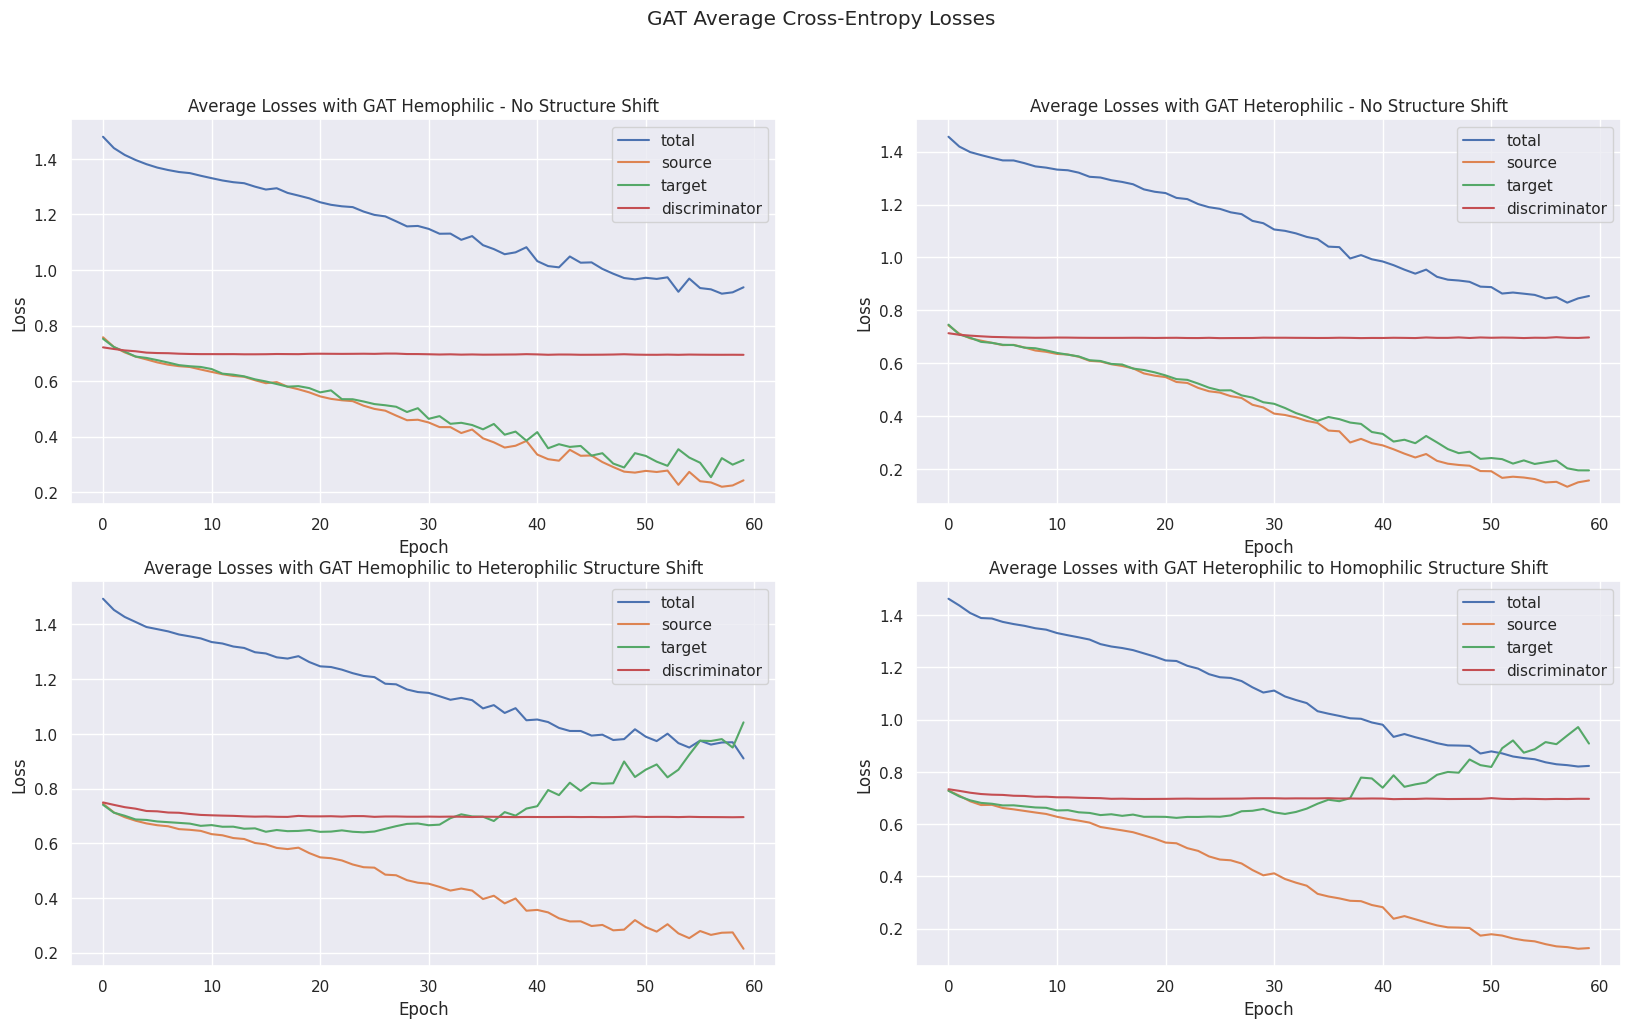

In [ ]:
import matplotlib.pyplot as plt

model = 'GAT'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['total', 'source', 'target', 'discriminator']




for exp_ind in range(n_experiments):
  plt.subplot(2,2, exp_ind + 1)

  key = experiments[exp_ind]
  plot_losses(results[key]['avg_losses'], title=f'Average Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()

## Source Structure Effect

In [ ]:
model = 'GCN'

print(f'{model} Transfer Results\n')

for target_struct_ind in range(n_target_probs):
  print("\n\n\n")
  for exp_ind in range(n_experiments):
    experiment_key = experiments[exp_ind]
    experiment_description = experiments_descriptions[exp_ind]
    src_accs = all_results[target_struct_ind][experiment_key]['src_accs']
    tgt_accs = all_results[target_struct_ind][experiment_key]['tgt_accs']

    print(experiment_description)
    print(f'Source Accuracy: mean = {src_accs.mean():.4f}, variance = {src_accs.var():.4f}')
    print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, variance = {tgt_accs.var():.4f}')
    print("\n\n")


GCN Transfer Results





Structure 1
Source Accuracy: mean = 1.0000, variance = 0.0000
Target Accuracy: mean = 0.9733, variance = 0.0097



Structure 2
Source Accuracy: mean = 0.9882, variance = 0.0006
Target Accuracy: mean = 0.9738, variance = 0.0057



Structure 3
Source Accuracy: mean = 0.6848, variance = 0.0044
Target Accuracy: mean = 0.8822, variance = 0.0340



Structure 4
Source Accuracy: mean = 0.9865, variance = 0.0004
Target Accuracy: mean = 0.9610, variance = 0.0105



Structure 5
Source Accuracy: mean = 1.0000, variance = 0.0000
Target Accuracy: mean = 0.9965, variance = 0.0001







Structure 1
Source Accuracy: mean = 0.9997, variance = 0.0000
Target Accuracy: mean = 0.9665, variance = 0.0079



Structure 2
Source Accuracy: mean = 0.9903, variance = 0.0002
Target Accuracy: mean = 0.9725, variance = 0.0082



Structure 3
Source Accuracy: mean = 0.6440, variance = 0.0052
Target Accuracy: mean = 0.9403, variance = 0.0166



Structure 4
Source Accuracy: mean = 0.9830, varian

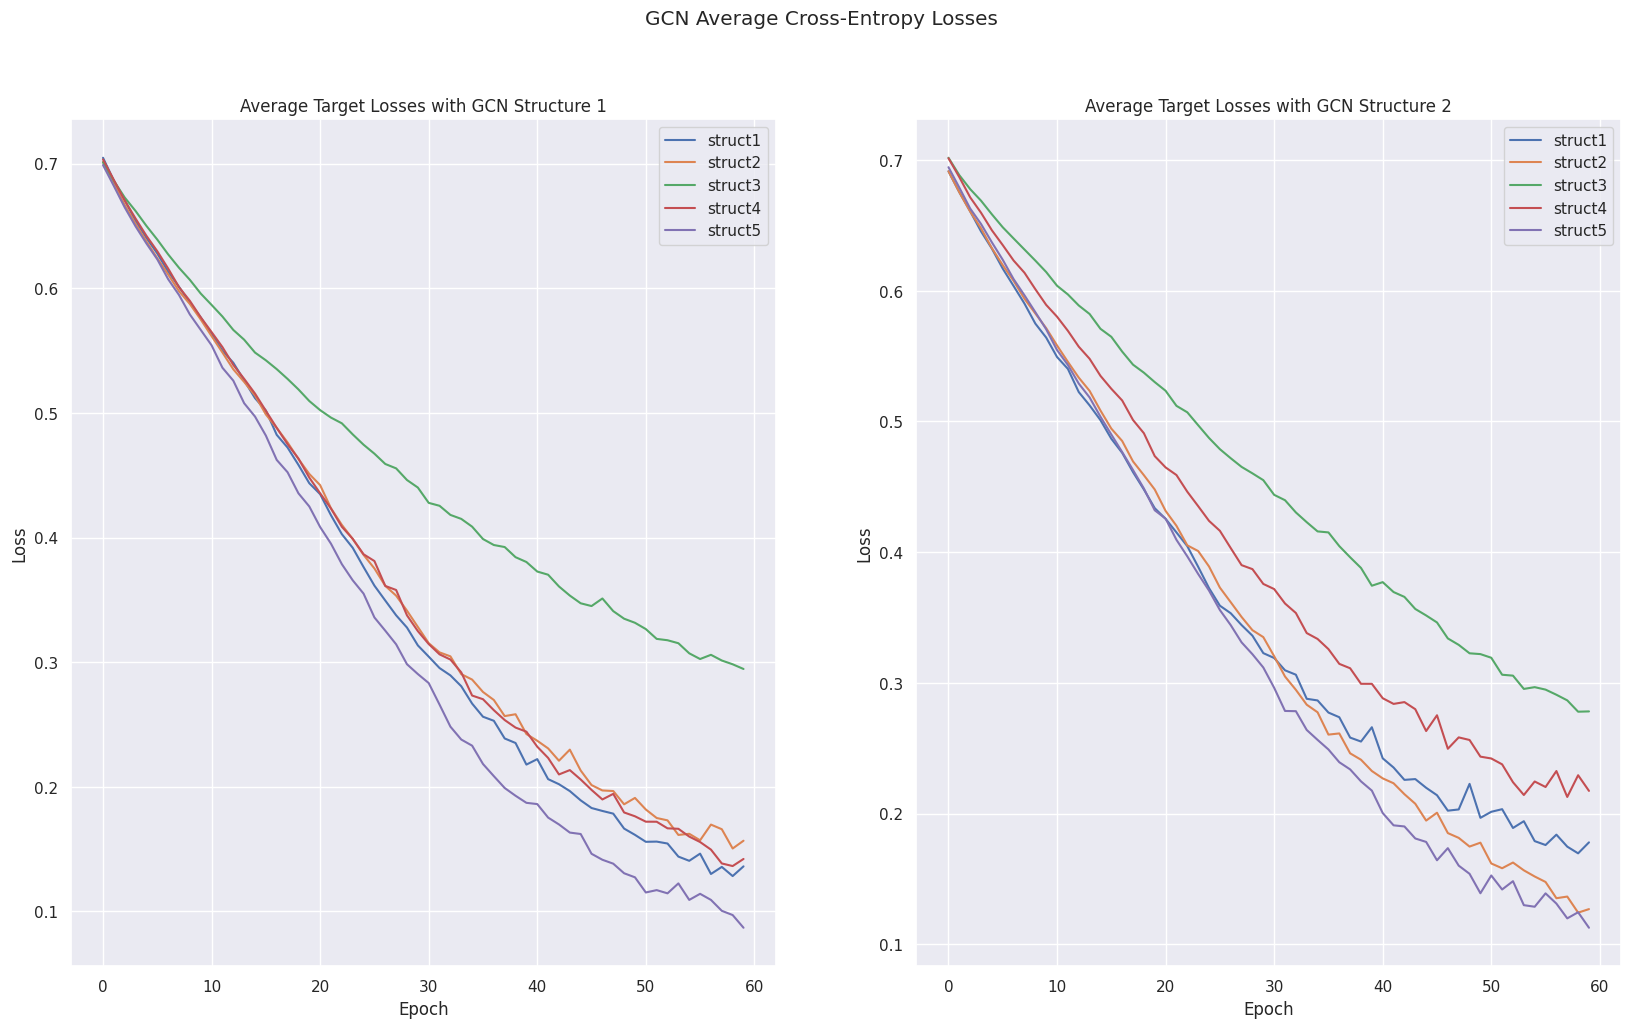

In [ ]:
import matplotlib.pyplot as plt

model = 'GCN'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']



# create test dictionary
target_losses = [dict(), dict()]

for i in range(2):

  for key in avg_losses_keys:
    target_losses[i][key] = all_results[i][key]['avg_losses']['target']


for exp_ind in range(n_target_probs):
  plt.subplot(1,2, exp_ind + 1)

  plot_losses(target_losses[exp_ind], title=f'Average Target Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()

## Edges

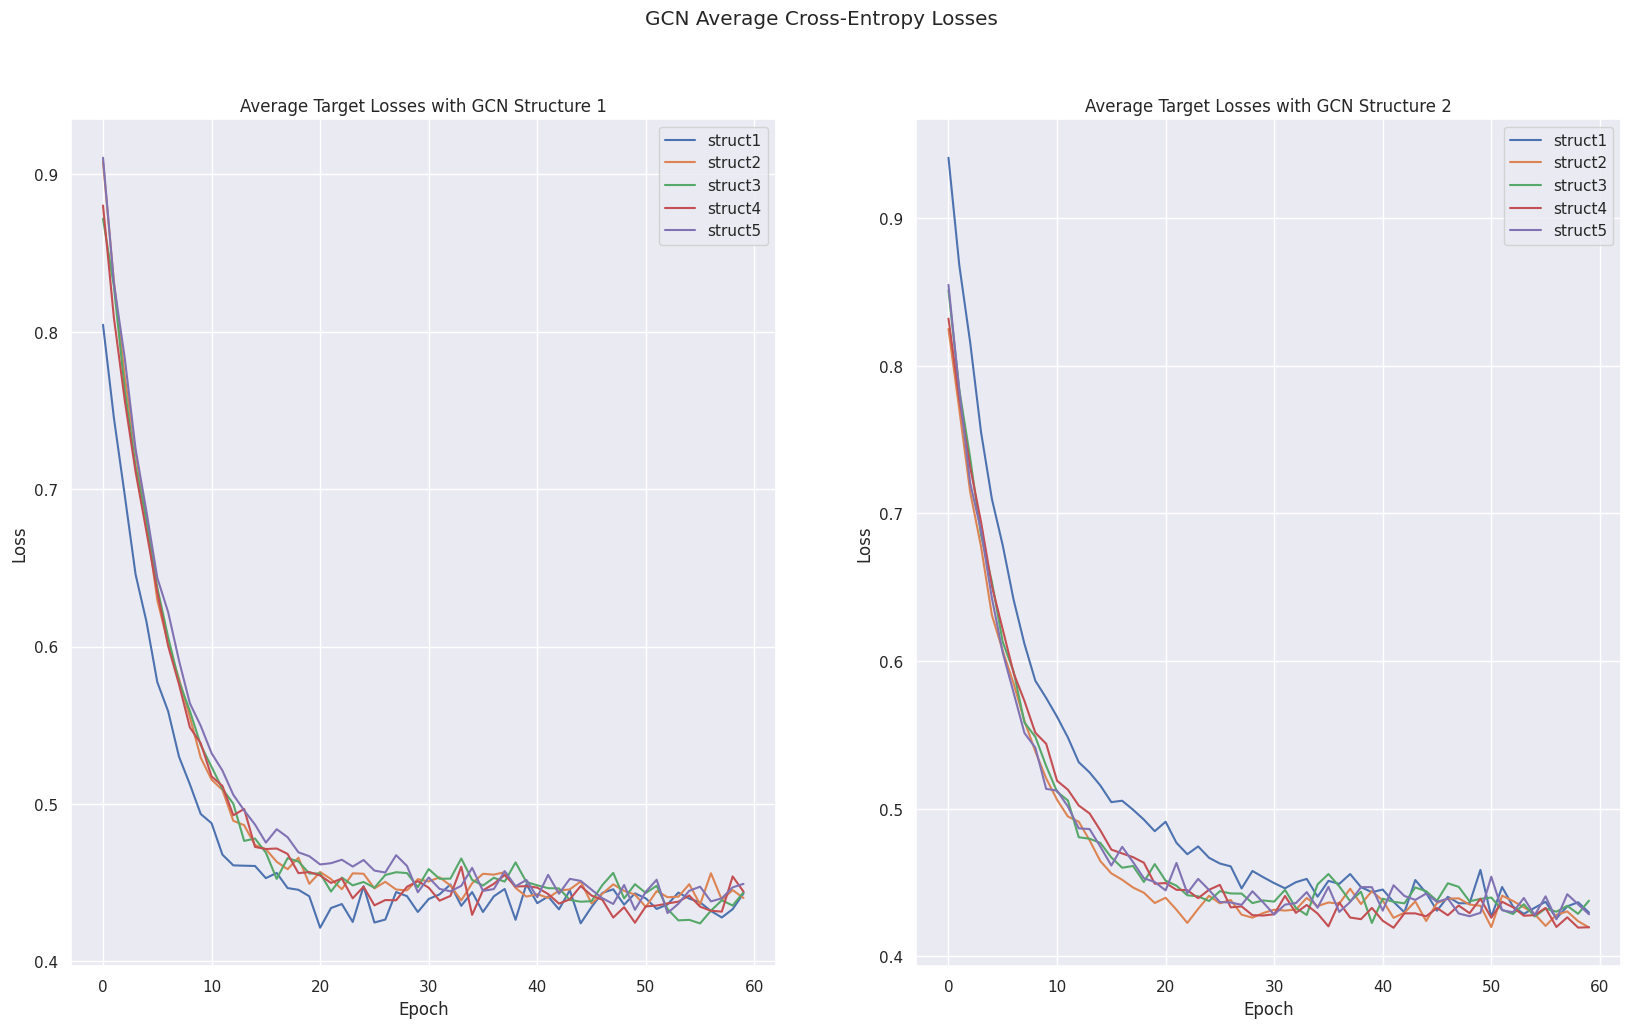

In [ ]:
import matplotlib.pyplot as plt

model = 'GCN'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']



# create test dictionary
target_losses = [dict(), dict()]

for i in range(2):

  for key in avg_losses_keys:
    target_losses[i][key] = all_results[i][key]['avg_losses']['target']


for exp_ind in range(n_target_probs):
  plt.subplot(1,2, exp_ind + 1)

  plot_losses(target_losses[exp_ind], title=f'Average Target Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()